In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [110]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [111]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


/var/folders/8z/fnblqgd55213h_1ltnz5z4xh0000gn/T/ipykernel_24599/2038653828.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


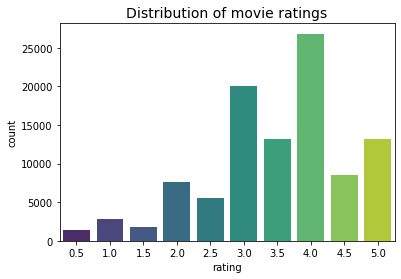

In [112]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [113]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [114]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

In [115]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [116]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [117]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Lamerica may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the Bayesian Average, which in this case, is a blend of the overall average (our prior) and the movie's average. 

#### Bayesian Average
[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior $m$ will be the average mean rating across all movies. By definition, C represents the typical data set size. Let's make $C$ be the average number of ratings for a given movie. If the movie has the same number of ratings as an an average movie (around 10), the average is a 50-50 blend. So low rated movies are bumped up and high rated movies are bumped down, and this blending is adjusted as the sample size and credibility increase.

In [118]:
# note these are explicit ratings. some people say implicit ratings (e.g. minutes watched) has less bias
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head(53)

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429
6,102,3.946078
7,54,3.185185
8,8,2.875000
9,16,3.125000


In [119]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings: pd.Series) -> float:
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [120]:
# let's test out our Bayesian average on Lamerica, which had two ratings of 5 stars. 
# The average should come down a lot towards our prior assumption (the pop avg)
lamerica = pd.Series([5, 5]) 
bayesian_avg(lamerica) # takes a pd.Series() as input

3.543

In [121]:
#Let's now apply bayesian_avg to all movies in our dataset.
# Our bayesian function takes in a pandas data series and returns a float or int, just like mean and count
 # reset_index() in this new table does just that. it resets the tables index after groupby results scrambled them
# the index in the table is a row identifier.

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg'] # we want to call our new column "bayesian_avg", not "rating" now
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [122]:
movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105


In [123]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']]) # inner join on movieId, bringing over title, but not including genre
movie_stats.sort_values('bayesian_avg', ascending=False).head()

# notice that lamerica is no longer at the top... Bayesian average brought it down because it only had 2 samples/reviews

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [124]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


In [125]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [126]:
# movie dataset cleaning (clean up string)
movies['genres'] = movies['genres'].apply(lambda x: x.split("|")) # similar to .map(), but can't apply function to entire rows/cols of a dataframe
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [127]:
# how many genres?
from collections import Counter

# the parentheses play two roles, for both the Counter object and the generator comprehension
genre_frequency = Counter(g for genres in movies['genres'] for g in genres) # Counter is a "+= 1" defaultDict(int) kind of object
print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [128]:
# note: the most_common() method of Counter must do some sorting of the values in the key-value pairs
# sortedDict maintains a sorted order on the keys, which isn't always helpful if you are interested in the values
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


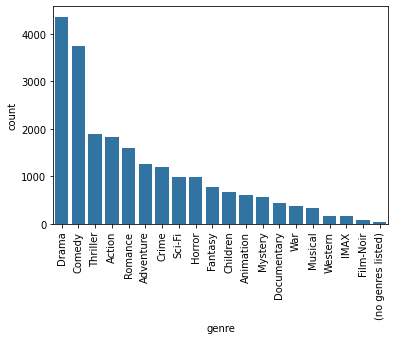

In [129]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### Step 4: Data Pre-processing
    
We are going to use a technique called collaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things.

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix, because it captures the utility each user (row) places on each object (column). 

The beauty of collaborative filtering is that it doesn't require any information about the users or the movies to generate recommendations.


In [170]:
# Note: most movies won't be rated by a user, so it makes sense to have a sparse representation of our utility matrix
# we'll use a Compressed Sparse Representation matrix from scipy

from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique() # rows
    N = df['movieId'].nunique() # cols

    # user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    # movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_mapper = {val: i for i, val in enumerate(np.unique(df["userId"]))}
    user_inv_mapper = {i: val for i, val in enumerate(np.unique(df["userId"]))}

    movie_mapper = {val: i for i, val in enumerate(np.unique(df["movieId"]))}
    movie_inv_mapper = {i: val for i, val in enumerate(np.unique(df["movieId"]))}
    
    # user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    # movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    # a Compressed Sparse Representation
    # takes in the non-zero entries data
    # the indices map the user data to the sparse matrix row and column, although the construction is a little complicated:
    # https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
    # [[1, 0, 2, 0],
    # [0, 0, 0, 3],
    # [4, 0, 0, 0]]
    # The non-zero values are [1, 2, 3, 4]. (data)
    # The corresponding row indices (users) are [0, 0, 1, 2] (the user_index list). (indices)
    # The corresponding column indices (items) are [0, 2, 3, 0] (the item_index list).
    # The indptr array would be [0, 2, 3, 4]:

    # indptr[0] = 0 means the non-zero values for row 0 start at index 0 in data and indices.
    # indptr[1] = 2 means the non-zero values for row 1 start at index 2 in data and indices.
    # indptr[2] = 3 means the non-zero values for row 2 start at index 3 in data and indices.
    # indptr[3] = 4 is the length of data and indices, marking the end of the matrix.

    # So indptr does not directly store the row indices themselves, but rather the start and end indices of non-zero values for each row in the data and indices arrays.
    # but by passing the rows and columns explicitly with (user_index, item_index), we don't need to worry about constructing indptr.
    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)


In [171]:
# shape: users X movies
print(type(X), dir(X))
X.shape

<class 'scipy.sparse.csr.csr_matrix'> ['__abs__', '__add__', '__array_priority__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__idiv__', '__imul__', '__init__', '__init_subclass__', '__isub__', '__iter__', '__itruediv__', '__le__', '__len__', '__lt__', '__matmul__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__pow__', '__radd__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rmatmul__', '__rmul__', '__round__', '__rsub__', '__rtruediv__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '_add_dense', '_add_sparse', '_arg_min_or_max', '_arg_min_or_max_axis', '_asindices', '_binopt', '_cs_matrix__get_has_canonical_format', '_cs_matrix__get_sorted', '_cs_matrix__set_has_canonical_format', '_cs_matrix__set_sorted', '_deduped

(610, 9724)

In [181]:
# how does CSR matrix compare in size
# https://nedbatchelder.com/blog/202002/sysgetsizeof_is_not_what_you_want.html
import sys

non_sparse = [[f"a string that isn't an int {i, j}" for i in range(len(np.unique(ratings["movieId"])))] for j in range(len(np.unique(ratings["userId"])))]
# non_sparse = [[0 for i in range(len(np.unique(ratings["movieId"])))] for j in range(len(np.unique(ratings["userId"])))]
print(len(non_sparse), len(non_sparse[0]))
non_sparse_numpy_matrix = np.zeros((len(non_sparse), len(non_sparse[0])))
print(non_sparse_numpy_matrix.shape)

def get_size(obj, seen=None):
    """Recursively find the total size of an object and its members"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj, (list, tuple, set, frozenset)):
        for item in obj:
            size += get_size(item, seen)
    elif isinstance(obj, dict):
        for key, value in obj.items():
            size += get_size(key, seen)
            size += get_size(value, seen)
    elif isinstance(obj, csr_matrix):
        size += obj.data.nbytes  # size of data array
        size += obj.indptr.nbytes  # size of indptr array; index pointers; https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
        size += obj.indices.nbytes  # size of indices array
    return size

print(f"{sys.getsizeof(X):,}", "bytes (for CSR)")
print(f"{get_size(X):,}", "bytes (for CSR with underlying object sizes added too)")
print(f"{sys.getsizeof(non_sparse):,}", "bytes (for nested list)")
print(f"{get_size(non_sparse):,}", "bytes (for nested list with underlying objects)")
print(f"{sys.getsizeof(non_sparse_numpy_matrix):,}", "bytes (numpy matrix according to getsizeof() looks to include everything)")
print(f"{non_sparse_numpy_matrix.nbytes:,}", "bytes (numpy matrix according to numpy)")
print(f"{get_size(non_sparse_numpy_matrix):,}", "bytes (numpy matrix according to custom function)")
print(f"Memory ratio: {get_size(X)/get_size(non_sparse_numpy_matrix):.2f}")
print(f"Memory ratio: {round(get_size(X)/get_size(non_sparse_numpy_matrix), 2)}")


610 9724
(610, 9724)
48 bytes (for CSR)
1,212,524 bytes (for CSR with underlying object sizes added too)
5,432 bytes (for nested list)
566,268,732 bytes (for nested list with underlying objects)
47,453,248 bytes (numpy matrix according to getsizeof() looks to include everything)
47,453,120 bytes (numpy matrix according to numpy)
47,453,248 bytes (numpy matrix according to custom function)
Memory ratio: 0.03
Memory ratio: 0.03


## Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix (nnz) is equivalent to the number of ratings in our dataset.

In [182]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz # non-empty elements
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")
print(f"Memory ratio: {round(get_size(X)/get_size(non_sparse_numpy_matrix)*100, 2)}%")

Matrix sparsity: 1.7%
Memory ratio: 2.56%


The cold start problem is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [188]:
n_ratings_per_user = X.getnnz(axis=1)
print(n_ratings_per_user)
len(n_ratings_per_user)

[ 232   29   39  216   44  314  152   47   46  140   64   32   31   48
  135   98  105  502  703  242  443  119  121  110   26   21  135  570
   81   34   50  102  156   86   23   60   21   78  100  103  217  440
  114   48  399   42  140   33   21  310  359  130   20   33   25   46
  476  112  107   22   39  366  271  517   34  345   36 1260   46   62
   35   45  210  177   69  119   29   61   64  167   26  227  118  293
   34   70   21   56  518   54  575   24   97   56  168   78   36   92
   53  148   61   56  377  273  722   33   34   76  127   51  646   65
  150   31  112   87  165   22  215   22   58  292   56   50  360   38
   22   33  140   28   69  347   35   35  279  111  141   22  194  608
  168   38   71  128   23   32   20   48   58   26   59   63  179   34
   46  398   21   26   97  437   39   38   23   36   65  190  173   94
  269   50   82   26   25   67   24   36  904   77   69   24  118  977
   57  134   47  226  258   48   20   66   85   22   35   20  187   32
   35 

610

In [185]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [186]:
n_ratings_per_movie = X.getnnz(axis=0)
print(n_ratings_per_movie)
len(n_ratings_per_movie)

[215 110  52 ...   1   1   1]


9724

In [187]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


/var/folders/8z/fnblqgd55213h_1ltnz5z4xh0000gn/T/ipykernel_24599/3364525973.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
/var/folders/8z/fnblqgd55213h_1ltnz5z4xh0000gn/T/ipykernel_24599/3364525973.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


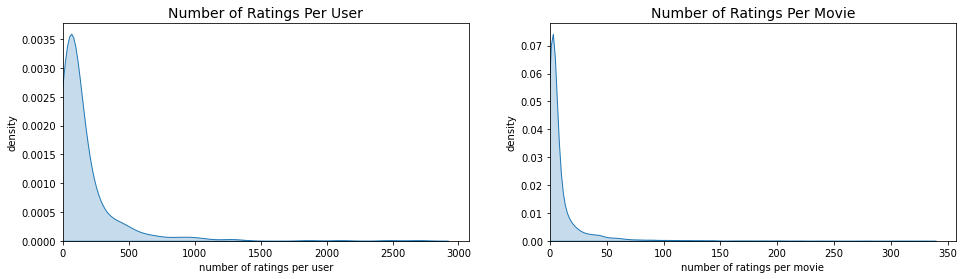

In [189]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

## Step 5: Item-item Recommendations with k-Nearest Neighbors
 
We are going to find the k movies that have the most similar user engagement vectors for movie i.

In [190]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

find_similar_movies() takes in a movieId and X matrix, and outputs a list of 
 movies that are similar to the movieId of interest.

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [191]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

find_similar_movies() returns a list of movieId's that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps movieId to title.

In [192]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


The results above show the 10 movies that are most similar to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach.

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [193]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)


## Step 6: Handling the cold-start problem
Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the cold start problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the genres column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [194]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [195]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [196]:
movie_genres.head()

,Horror,Mystery,Musical,Romance,Thriller,Film-Noir,Sci-Fi,Drama,Children,(no genres listed),IMAX,Animation,Western,Action,War,Comedy,Documentary,Fantasy,Adventure,Crime
0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [197]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


As expected, after passing the movie_genres dataframe into the cosine_similarity() function, we get a cosine similarity matrix of shape 
.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

## Creating a movie finder function
Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset.

In our dataset, Jumanji is actually listed as 'Jumanji (1995)'. If we misspell Jumanji or forget to include its year of release, our recommender won't be able to identify which movie we're interested in.

To make our recommender more user-friendly, we can use a Python package called fuzzywuzzy which will find the most similar title to a string that you pass in. Let's create a function called movie_finder() which take advantage of fuzzywuzzy's string matching algorithm to get the most similar title to a user-inputted string.

In [199]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

/Applications/anaconda3/envs/data_science/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [200]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

To get relevant recommendations for Jumanji, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

Let's create a movie index dictionary called movie_idx where the keys are movie titles and values are movie indices:

In [201]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


Using this handy movie_idx dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [202]:

n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

similar_movies is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe.

In [203]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object

Cool! These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s.

We can test our recommender further with other movie titles. For your convenience, let's package the steps into a single function which takes in the movie title of interest and number of recommendations.

In [204]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [205]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object


## Step 7: Dimensionality Reduction with Matrix Factorization (advanced)
Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

user-factor matrix (n_users, k)
item-factor matrix (k, n_items)
We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature 
 represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

In [206]:
from sklearn.decomposition import TruncatedSVD
# see: https://www.youtube.com/watch?v=ZspR5PZemcs

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [207]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)


The results above are the most similar movies to Toy Story using kNN on our “compressed” movie-factor matrix. We reduced the dimensions down to n_components=20. We can think of each component representing a latent feature such as movie genre.